## Integral by Interpolation ##

We want to use a NN to calculate the integral $I$ of a polynomial function in the form of: 

$$I = \int_{0}^{B} (αx^2 + βx + γ)\, dx \, \Longrightarrow$$ 
$$ = \frac{α}{3}B^3 + \frac{β}{2}B^2 + γB $$ 

In [2]:
# Modules 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm

# Paths
images_path = '/home/lsantiago/workspace/ic/Relatorio/Imagens'
data_path = '/home/lsantiago/workspace/ic/data'
models_path = '/home/lsantiago/workspace/ic/models'

Define NN architecture

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() 
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        ) 
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)


Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)


Get dataset

In [30]:
def generate_data(n_samples=500):
    alpha_beta_gamma_B = np.random.rand(n_samples, 4)  # polynomial coefficients (α, β, γ, B), in the interval [0, 1]
    integrals = np.zeros((n_samples, 1))
    
    for i in range(n_samples):
        alpha, beta, gamma, B = alpha_beta_gamma_B[i]
        integrals[i] = (alpha / 3) * B**3 + (beta / 2) * B**2 + gamma * B  # Polynomial's defined integral

    return alpha_beta_gamma_B, integrals

Defining model

In [31]:
# Convert np to torch
def numpy_to_torch(data):
    return torch.tensor(data, dtype=torch.float32)

# Creating model
model = NeuralNetwork()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Get and split dataset

In [32]:
X, y = generate_data()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = numpy_to_torch(X_train)
y_train_tensor = numpy_to_torch(y_train)

X_val_tensor = numpy_to_torch(X_val)
y_val_tensor = numpy_to_torch(X_val)

Train the model

  0%|          | 0/100 [00:00<?, ?it/s]/home/lsantiago/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100, 4])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:01<00:00, 83.52it/s]


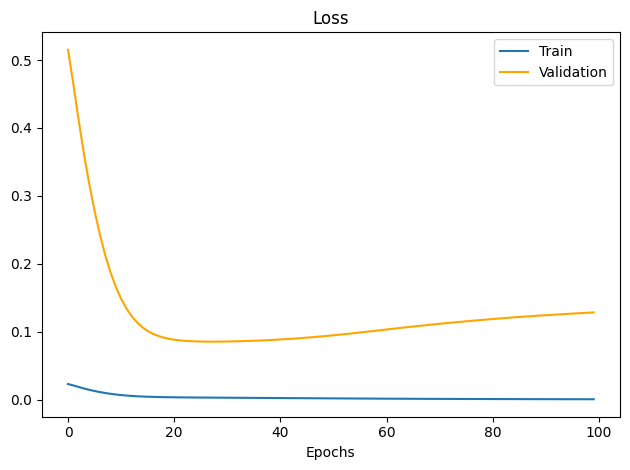

Saved PyTorch Model State to /home/lsantiago/workspace/ic/models


In [33]:
def train_model(model, X_train, y_train,X_val, y_val, epochs=50, batch_size=32):
    train_loss_values = []
    val_loss_values = []
    for epoch in tqdm(range(epochs)):
        running_train_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_train_loss =+ loss.item() * X_batch.size(0)
            model.eval()

        train_loss_values.append(running_train_loss / len(X_train))

        with torch.no_grad():
            outputs_val = model(X_val)
            val_loss = criterion(outputs_val, y_val)
            val_loss_values.append(val_loss.item())

    plt.plot(train_loss_values, label='Train')
    plt.plot(val_loss_values, label='Validation', color='orange')
    plt.xlabel('Epochs')
    plt.title('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# train_model(model, X_train_tensor, y_train_tensor, X

Test model

In [34]:
X_test_tensor = numpy_to_torch(X_val)
y_test_tensor = numpy_to_torch(y_val)
outputs = model(X_test_tensor)
loss = criterion(outputs, y_test_tensor)
print(f'Loss: {loss.item()}')

Loss: 0.008257744833827019


### Validation example ($\frac{1}{2}x^2 + \frac{8}{10}x + \frac{3}{10}$ from zero to $\frac{1}{2}$)

Analytic solution: 

$$ \int_{0}^{\frac{1}{2}} (\frac{1}{2}x^2 + \frac{8}{10}x + \frac{3}{10})\,dx \ \Longrightarrow $$
$$ \left[ \frac{1}{6}x^3 + \frac{2}{5}x^2 + \frac{3}{10}x \right]_0^\frac{1}{2} \Longrightarrow $$
$$ = \frac{1}{48} + \frac{1}{10} + \frac{3}{20} \Longrightarrow $$
$$ = 0.2708.. $$


In [35]:
test_poly = [0.5, 0.8, 0.3, 0.5]

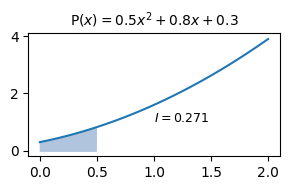

In [36]:
# Test

alpha, beta, gamma, B = test_poly
ans = (alpha / 3) * B**3 + (beta / 2) * B**2 + gamma * B 

curve = np.array([alpha, beta, gamma,])

x = np.linspace(0,2, num=50) # B=2
y = [np.polyval(curve, i) for i in x]

x_size, y_size = 3, 2
fig, axs = plt.subplots(figsize=(x_size, y_size))
axs.plot(x,y)
axs.set_title(f"P$(x) = {alpha}x^2 + {beta}x + {gamma}$", size=10)
axs.text(x_size/3, y_size/2, s=f'$I={ans:.3f}$', size=9)

fill = B
arg, = np.argwhere(x<=fill)[-1] + 1

plt.fill_between(x[:arg], y[:arg], color='lightsteelblue')
# plt.grid()
plt.tight_layout()

Prediction:

In [37]:
new_coefficients = numpy_to_torch(np.array([[alpha, beta, gamma, B]])) 
predicted_integral = model(new_coefficients)
print(f'''Prediction: {predicted_integral.item():.3f}
Answer:     {ans:.3f}
Error:      {abs(predicted_integral.item() - ans)/ans:.3%}''')

Prediction: 0.363
Answer:     0.271
Error:      33.859%
